In [ ]:
# ******NOTE: use different instance of Normalization for extreme values

In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
#import data
df = pd.read_csv('../Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
#define train and label column
train_cols = ["Precipitation","Temperature","Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
#filter the columns that are used for training and testing
filtered_df = df.filter(train_cols, axis=1)

In [5]:
#To convert from hourly data to daily data
oflow = filtered_df['Outflow'].tolist()
tem = filtered_df['Temperature'].tolist()
precp = filtered_df['Precipitation'].tolist()

#Summing up the outflow data
lengthOfData = len(oflow)

#summing 24 hours outflow
totalOutflow = []
for i in range(0, lengthOfData, 24):
  totalOutflow.append(sum(oflow[i:i+24]))

#averaging 24 hours temperature
averageTemperature = []
for i in range(0, lengthOfData, 24):
  averageTemperature.append((sum(tem[i:i+24]))/24)

#summing 24 hours precipitation
totalPrecipitation = []
for i in range(0, lengthOfData, 24):
  totalPrecipitation.append(sum(precp[i:i+24]))

In [6]:
#new dataframe for daily data
new_df = pd.DataFrame({'Precipitation': totalPrecipitation, 'Temperature': averageTemperature, 
                       'Outflow': totalOutflow}, columns=['Precipitation', 'Temperature', 'Outflow'])

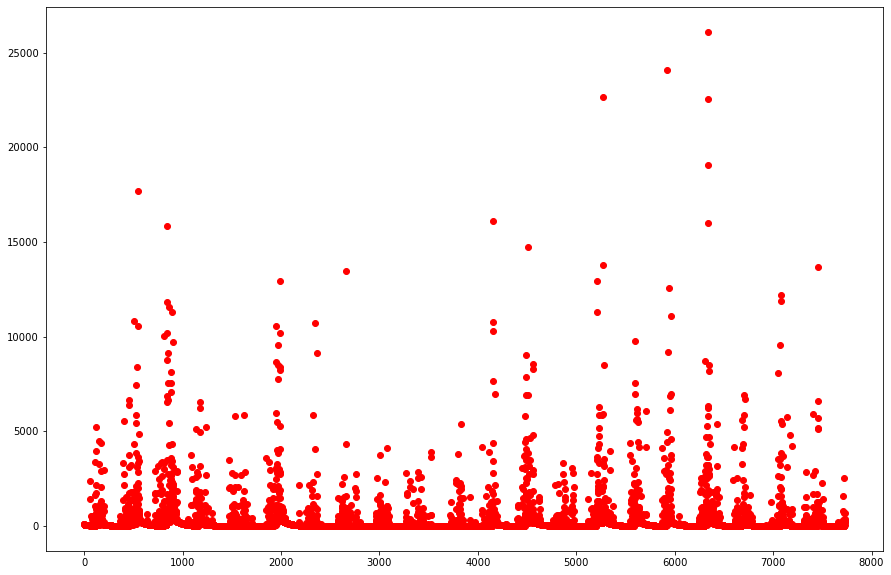

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(new_df['Outflow'], 'ro')
plt.show()

In [8]:
new_df['ExtremeOrNot'] = np.where(new_df['Outflow'] > 5000, 1, 0)

In [9]:
#dataframe for network 1 without extreme values
df_net1 = new_df[new_df['Outflow'] <= 5000]

In [10]:
#outflow shape without values greater 5000, and original hourly  data shape
df_net1.shape, df.shape

((7611, 4), (185544, 8))

In [11]:
#total days outflow
new_df.shape

(7731, 4)

In [12]:
#label of network for discriminator network
labels_discriminator = ["ExtremeOrNot"]

In [13]:
# #Min Max scalar normalizing
# xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
# ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
# xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
# ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
# #Min Max scalar normalizing for extreme values
# xtrain_min_max_scaler_ext = MinMaxScaler(feature_range = (0, 1))
# ytrain_min_max_scaler_ext = MinMaxScaler(feature_range = (0, 1))
# xtest_min_max_scaler_ext = MinMaxScaler(feature_range = (0, 1))
# ytest_min_max_scaler_ext = MinMaxScaler(feature_range = (0, 1))

In [14]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

#calling function to create lag dataframe for network 3
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

#calling function to create lag dataframe for network 1
lag_df_net1 = lag_seq(df_net1, 1)
lag_df_net1.dropna(inplace=True)

#Splitting training and test data for network 3
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
#splitting training and test data for network 1
df_train_net1, df_test_net1 = train_test_split(lag_df_net1, train_size=0.8, test_size=0.2, shuffle=False)
#train for network3
x_train3 = df_train.loc[:,train_cols].values
y_train3 = df_train.loc[:,labels_discriminator].values  #for discriminator
# train data for network1
x_train1 = df_train_net1.loc[:,train_cols].values
y_train1 = df_train_net1.loc[:,label_cols].values
#test data for network3
x_test3 = df_test.loc[:,train_cols].values
y_test3 = df_test.loc[:,labels_discriminator].values    #for discriminator
#test data for network 1
x_test1 = df_test_net1.loc[:,train_cols].values
y_test1 = df_test_net1.loc[:,label_cols].values 

/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [15]:
# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [25]:
# building timeseries data with given timesteps
def timeseries1(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1]
        Y_values_actual[i] = Y_actual[time_steps+i-1]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [16]:
# checking mse for train set that are greater than threshold
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

threshold = 5000
timesteps = 18
train_values_above_thres = []
train_labels_above_theres = []

for i in range(timesteps, x_train.shape[0]):
    if (y_train[i] > threshold):
        train_values_above_thres.append(x_train[i-timesteps:i])
        train_labels_above_theres.append(y_train[i]) 
        
X_Train_abv_thres = np.array(train_values_above_thres)
Y_Train_abv_thres = np.array(train_labels_above_theres)

# tsamples, ta, tb = X_train_abv_thres.shape
# x_train_for_normalization = X_train_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
# x_train_for_normalization.shape

# X_Train_abv_thres = xtrain_min_max_scaler_ext.fit_transform(x_train_for_normalization)
# Y_Train_abv_thres = ytrain_min_max_scaler_ext.fit_transform(Y_train_abv_thres)

# X_Train_abv_thres = X_Train_abv_thres.reshape((tsamples, ta, tb))

In [17]:
# checking mse for test set that are greater than threshold
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_Test_abv_thres = np.array(test_values_above_thres)
Y_Test_abv_thres = np.array(test_labels_above_theres)

# tsamples, ta, tb = X_test_abv_thres.shape
# x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
# x_test_for_normalization.shape

# X_Test_abv_thres = xtest_min_max_scaler_ext.fit_transform(x_test_for_normalization)
# Y_Test_abv_thres = ytest_min_max_scaler_ext.fit_transform(Y_test_abv_thres)

# X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

In [18]:
#data for Network1
def data_processing(x_train, y_train, x_test, y_test): 
   
#     #Normalizing training data
#     x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
#     y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

#     # Normalizing test data
#     x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
#     y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train, y_train, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test, y_test, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [26]:
# data for Network3
def data_processing1(x_train, y_train, x_test, y_test): 
   
#     #Normalizing training data
#     x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)

#     # Normalizing test data
#     x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    #SMOTE algorithm
    sm = SMOTE(random_state = 2)
    x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())
    
    # Saving actual train and test y_label
    y_train_actual = y_train_res
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries1(x_train_res, y_train_res, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test, y_test, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [27]:
#calling function to create lag dataframe
X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual = data_processing(x_train1, 
                                                                                  y_train1, 
                                                                                  x_test1, 
                                                                                  y_test1)
#calling function to create lag dataframe for distinguisher network
X_Train_dis, Y_Train_dis, Y_train_actual_dis, X_Test_dis, Y_Test_dis, Y_test_actual_dis = data_processing1(x_train3, 
                                                                                                          y_train3, 
                                                                                                          x_test3, 
                                                                                                          y_test3)

/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (6069, 18, 3) (6069,)



length of time-series i/o (1504, 18, 3) (1504,)


/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (12170, 18, 3) (12170,)



length of time-series i/o (1528, 18, 3) (1528,)


In [28]:
## check for all the values in network 1 and create a dataframe to handpick values from network 1 or network 2
X_Train1, Y_Train1, Y_train_actual1, X_Test1, Y_Test1, Y_test_actual1 = data_processing(x_train, 
                                                                                  y_train, 
                                                                                  x_test, 
                                                                                  y_test)

/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (6166, 18, 3) (6166,)



length of time-series i/o (1528, 18, 3) (1528,)


In [29]:
# for classification network, we should use categorical labels
Y_Train_disc = to_categorical(Y_Train_dis)
Y_Test_disc = to_categorical(Y_Test_dis)

In [30]:
#Network 1 for normal values
def make_model(X_Train):
    inp = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
    #build modelA
    lstm1 = LSTM(units=16, return_sequences=True, 
                   name = 'lstm1A')(inp)
#     do1A = Dropout(0.2, name = 'do1A')(lstm1A)
    lstm2 = LSTM(units=32, return_sequences=True,
                  name = 'lstm2A')(lstm1)
#     do2A = Dropout(0.2, name = 'do2A')(lstm2A)
    lstm3 = LSTM(units=64, name = 'lstm3A')(lstm2)
#     do3A = Dropout(0.2, name = 'do3A')(lstm3A)
    
    dense1 = Dense(128, activation='relu')(lstm3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=inp, outputs=output_layer)

#Network 2 for extreme values
def make_model1(X_Train):
    inp = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
    #build modelA
    lstm1 = LSTM(units=16, return_sequences=True, 
                   name = 'lstm1A')(inp)
#     do1A = Dropout(0.2, name = 'do1A')(lstm1A)
    lstm2 = LSTM(units=32, return_sequences=True,
                  name = 'lstm2A')(lstm1)
#     do2A = Dropout(0.2, name = 'do2A')(lstm2A)
    lstm3 = LSTM(units=64, name = 'lstm3A')(lstm2)
#     do3A = Dropout(0.2, name = 'do3A')(lstm3A)
    
    dense1 = Dense(128, activation='relu')(lstm3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=inp, outputs=output_layer)

#Network 3 for distinguishing which network's output to be used
def make_model2(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    conv1 = Conv1D(filters=16, kernel_size=3, strides=1,
                    padding='same',activation='relu')(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv1)
    conv3 = Conv1D(filters=64, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv2)

    flatten = Flatten()(conv3)

    dense1 = Dense(1152, activation='relu')(flatten)
    dense2 = Dense(576, activation='relu')(dense1)
    output_layer = Dense(2, activation='softmax')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [31]:
# Network1 Training
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []
models = []
def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        #predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values)
        models.append(model)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values, model

predicted_y_values_unnor, model = run_iteration(1,10)

Iteration: 1
Train on 6069 samples, validate on 1504 samples
Epoch 1/10
6069/6069 [==============================] - 22s 4ms/step - loss: 1059648.0632 - val_loss: 1426381.8897
Epoch 2/10
6069/6069 [==============================] - 18s 3ms/step - loss: 890926.2313 - val_loss: 1202100.4975
Epoch 3/10
6069/6069 [==============================] - 18s 3ms/step - loss: 791746.9652 - val_loss: 1237070.9690
Epoch 4/10
6069/6069 [==============================] - 18s 3ms/step - loss: 790039.0003 - val_loss: 1148878.8678
Epoch 5/10
6069/6069 [==============================] - 18s 3ms/step - loss: 787522.3372 - val_loss: 1141185.4810
Epoch 6/10
6069/6069 [==============================] - 17s 3ms/step - loss: 771696.1801 - val_loss: 1181911.4390
Epoch 7/10
6069/6069 [==============================] - 18s 3ms/step - loss: 823282.2803 - val_loss: 1190179.1495
Epoch 8/10
6069/6069 [==============================] - 18s 3ms/step - loss: 785325.4545 - val_loss: 1153909.6012
Epoch 9/10
6069/6069 [====

In [32]:
# Network2 Training
mse_for_iter1 = []
train_loss_over_epoch1 = []
val_loss_over_epoch1 = []
predicted_y_values_unnors1 = []
models1 = []
def run_iteration1(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model1 = make_model1(X_Train_abv_thres)
        #plot_model(model, show_shapes=True)
        model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model1.fit(X_Train_abv_thres, Y_Train_abv_thres, epochs=epochs,
                       validation_data=(X_Test_abv_thres, Y_Test_abv_thres))
        train_loss_over_epoch1.append(history.history['loss'])
        val_loss_over_epoch1.append(history.history['val_loss'])
        predicted_y_values1 = model1.predict(X_Test1)
        #predicted_y_values_unnor1 = ytrain_min_max_scaler_ext.inverse_transform(predicted_y_values1)
        mse_for_iter1.append(mean_squared_error(predicted_y_values1, Y_test_actual1))
        predicted_y_values_unnors1.append(predicted_y_values1)
        models1.append(model1)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values1, model1

predicted_y_values_unnor1, model1 = run_iteration1(1,10)

Iteration: 1
Train on 90 samples, validate on 30 samples
Epoch 1/10
90/90 [==============================] - 4s 40ms/step - loss: 87697133.1556 - val_loss: 109119016.0000
Epoch 2/10
90/90 [==============================] - 0s 3ms/step - loss: 87693050.3111 - val_loss: 109113632.0000
Epoch 3/10
90/90 [==============================] - 0s 3ms/step - loss: 87686553.6000 - val_loss: 109103400.0000
Epoch 4/10
90/90 [==============================] - 0s 3ms/step - loss: 87674092.2667 - val_loss: 109083560.0000
Epoch 5/10
90/90 [==============================] - 0s 3ms/step - loss: 87651126.7556 - val_loss: 109050912.0000
Epoch 6/10
90/90 [==============================] - 0s 3ms/step - loss: 87617194.4889 - val_loss: 109009944.0000
Epoch 7/10
90/90 [==============================] - 0s 3ms/step - loss: 87575700.0889 - val_loss: 108960880.0000
Epoch 8/10
90/90 [==============================] - 0s 3ms/step - loss: 87524798.2222 - val_loss: 108899216.0000
Epoch 9/10
90/90 [====================

In [33]:
# Network3 Training
# mse_for_iter2 = []
train_loss_over_epoch2 = []
val_loss_over_epoch2 = []
all_actual_values = []
models2 = []
def run_iteration2(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model2 = make_model2(X_Train_dis)
        #plot_model(model, show_shapes=True)
        model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])
        history = model2.fit(X_Train_dis, Y_Train_disc, epochs=epochs,
                       validation_data=(X_Test_dis, Y_Test_disc))
        train_loss_over_epoch2.append(history.history['loss'])
        val_loss_over_epoch2.append(history.history['val_loss'])
        predicted_y_values2 = model2.predict(X_Test_dis)
#         predicted_y_values_unnor2 = ytrain_min_max_scaler.inverse_transform(predicted_y_values2)
#         mse_for_iter2.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        actual_values = np.argmax(predicted_y_values2, axis = 1)
#         predicted_y_values_unnors.append(actual_values)
        models2.append(model2)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return actual_values, model2

actual_values, model2 = run_iteration2(1,10)

Iteration: 1
Train on 12170 samples, validate on 1528 samples
Epoch 1/10
12170/12170 [==============================] - 16s 1ms/step - loss: 7.7009 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 2/10
12170/12170 [==============================] - 15s 1ms/step - loss: 7.6997 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 3/10
12170/12170 [==============================] - 15s 1ms/step - loss: 7.6997 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 4/10
12170/12170 [==============================] - 15s 1ms/step - loss: 7.6997 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 5/10
12170/12170 [==============================] - 15s 1ms/step - loss: 7.6997 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 6/10
12170/12170 [==============================] - 16s 1ms/step - loss: 7.6997 - accuracy: 0.4993 - val_loss: 0.3019 - val_accuracy: 0.9804
Epoch 7/10
12170/12170 [==============================] 

In [34]:
mse_for_iter

[1180447.0402997886]

In [35]:
mse_for_iter1

[2545059.3351867343]

In [36]:
unique, counts = np.unique(Y_Train_dis, return_counts=True)
dict(zip(unique, counts))

{0.0: 6077, 1.0: 6093}

In [37]:
cm = confusion_matrix(Y_Test_dis, actual_values)

In [38]:
#for creating confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('ConfusionMatrix.png', bbox_inches='tight')
    plt.show()

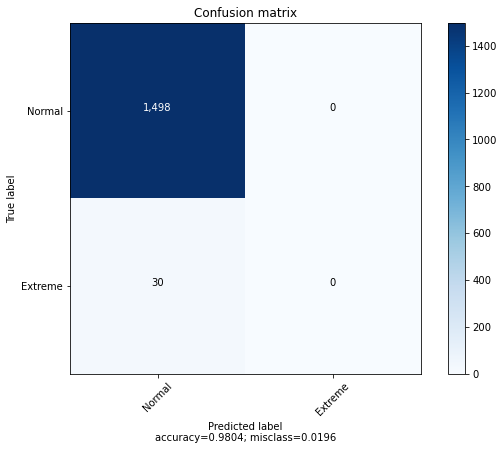

In [39]:
plot_confusion_matrix(cm, 
                      ['Normal', 'Extreme'], 
                      title='Confusion matrix',
                      cmap=None,
                      normalize=False)

## check for all the values in network 1 and create a dataframe to handpick values from network 1 or network 2

In [40]:
predicted_y_values_unnor = model.predict(X_Test1)
#predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)

In [41]:
type(predicted_y_values_unnor)

numpy.ndarray

In [42]:
result_df = pd.DataFrame(predicted_y_values_unnor, columns=['Network1'])

In [43]:
result_df

,Network1
0,21.357697
1,21.090815
2,20.947533
3,20.883209
4,20.868616
...,...
1523,1514.694458
1524,462.572327
1525,24.152754
1526,1280.064819


In [44]:
predicted_y_values_unnor1.shape

(1528, 1)

In [45]:
#predicted_y_values_unnor.reshape(1,-1)

In [46]:
result_df['Network2'] = predicted_y_values_unnor1

In [47]:
result_df['Discriminator'] = actual_values

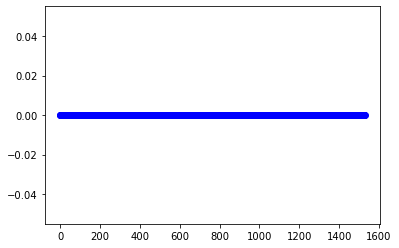

In [48]:
plt.plot(actual_values, 'bo')
plt.show()

In [49]:
np.unique(actual_values)

array([0])

In [50]:
result_df.head()

,Network1,Network2,Discriminator
0,21.357697,22.235937,0
1,21.090815,22.236078,0
2,20.947533,22.236086,0
3,20.883209,22.236120,0
4,20.868616,22.236237,0


In [51]:
np.zeros(len(result_df))


array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
result_df['Result'] = np.zeros(len(result_df))

In [53]:
result_df.Result[1]

0.0

In [54]:
result_df.head()

,Network1,Network2,Discriminator,Result
0,21.357697,22.235937,0,0.0
1,21.090815,22.236078,0,0.0
2,20.947533,22.236086,0,0.0
3,20.883209,22.236120,0,0.0
4,20.868616,22.236237,0,0.0


In [55]:
l = len(result_df)
for i in range(l):
    if result_df.Discriminator[i] == 1:
        result_df['Result'][i] = result_df.Network2[i]
    else:
        result_df['Result'][i] = result_df.Network1[i]

/Users/bidurbhurtel/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
result_df

,Network1,Network2,Discriminator,Result
0,21.357697,22.235937,0,21.357697
1,21.090815,22.236078,0,21.090815
2,20.947533,22.236086,0,20.947533
3,20.883209,22.236120,0,20.883209
4,20.868616,22.236237,0,20.868616
...,...,...,...,...
1523,1514.694458,22.274364,0,1514.694458
1524,462.572327,22.264450,0,462.572327
1525,24.152754,22.272684,0,24.152754
1526,1280.064819,22.276203,0,1280.064819


In [57]:
Y_Test1.shape

(1528,)

In [58]:
Y_test_actual1.shape

(1528,)

In [59]:
mean_squared_error(result_df['Result'], Y_test_actual1)

1770162.431544548

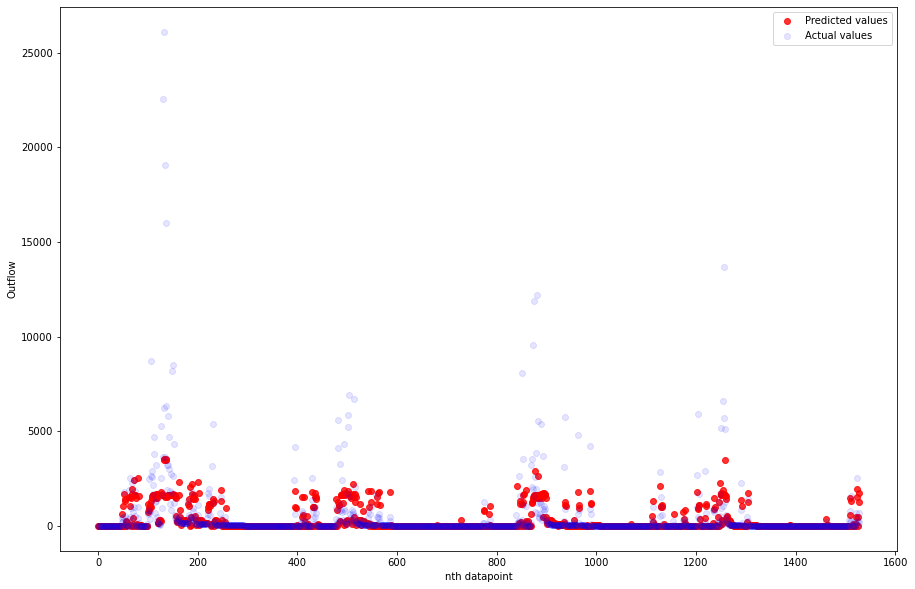

In [60]:
#plot predicted value vs actual values from last iteration
plt.figure(figsize=(15, 10))
plt.plot(result_df['Result'], 'ro', alpha=0.8)
plt.plot(Y_test_actual1, 'bo', alpha=0.1)
plt.legend(['Predicted values', 'Actual values'], loc='upper right')
plt.ylabel('Outflow')
plt.xlabel('nth datapoint')
plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
plt.show()